In [1]:
!pip install segmentation_models_pytorch

In [2]:
!pip install wandb
import wandb
wandb.login()
wandb.init(entity="ai_tech_level2-cv-18",project="Han_T2260",name="dlv3p_rxt50_25_psu")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ai_tech_level2-cv-18 (use `wandb login --relogin` to force relogin)


In [3]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.9.1+cu102
GPU 사용 가능 여부: True
Tesla V100-SXM2-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [4]:
batch_size = 8   # Mini-batch size
num_epochs = 25
learning_rate = 0.0001

In [5]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [6]:
%matplotlib inline

dataset_path  = '../input'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 20988
Number of images: 2617


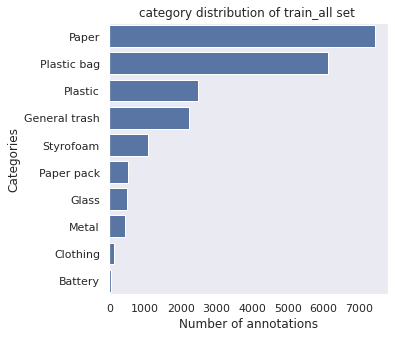

In [7]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [8]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [9]:
# class (Categories) 에 따른 index 확인 (0~10 : 총 11개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,2225.0
2,Paper,7448.0
3,Paper pack,527.0
4,Metal,449.0
5,Glass,488.0
6,Plastic,2472.0
7,Styrofoam,1074.0
8,Plastic bag,6114.0
9,Battery,50.0


## 데이터 전처리 함수 정의 (Dataset)

In [10]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [11]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train_all.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.augmentations.crops.transforms import RandomCrop
from albumentations.augmentations.geometric.rotate import RandomRotate90
from albumentations.augmentations.transforms import HorizontalFlip, VerticalFlip
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                        OneOf([
                            A.RandomResizedCrop(height=512,width=512,p=0.5),
                            A.HorizontalFlip(p=1.0),
                            A.VerticalFlip(p=1.0),
                        ],p=1.0),
                        A.RandomRotate90(p=1.0),
                        A.Cutout(p=0.75),
                        ToTensorV2()
                        ])

val_transform = A.Compose([
                        ToTensorV2()
                        ])

test_transform = A.Compose([
                        ToTensorV2()
                        ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=0,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=0,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=0,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=5.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [12]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [13]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {1, 'General trash'}, {'Plastic', 6}, {10, 'Clothing'}]


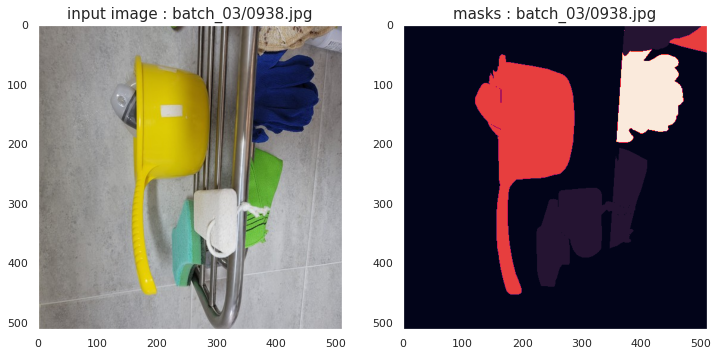

In [14]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {5, 'Glass'}, {'Plastic', 6}, {8, 'Plastic bag'}]


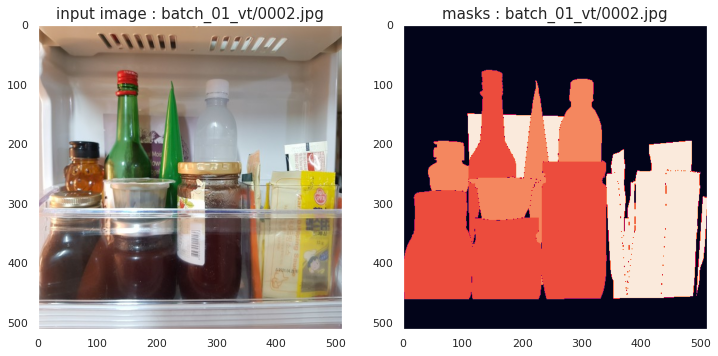

In [15]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


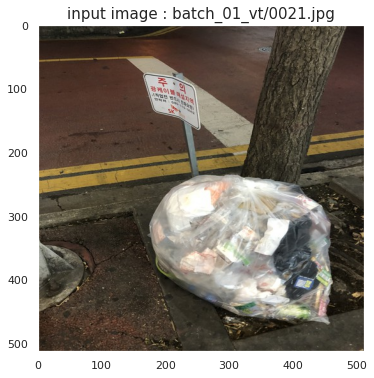

In [16]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### models.segmentation.fcn_resnet50

In [19]:
import torch
import segmentation_models_pytorch as smp

In [18]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
# model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model = smp.DeepLabV3Plus(encoder_name="resnext50_32x4d",upsampling=4, encoder_weights="imagenet",in_channels=3,classes=11).to(device)

# output class를 data set에 맞도록 수정
# model.classifier[4] = nn.Conv2d(256, 11, kernel_size=1)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
x = torch.randn([2, 3, 512, 512]).to(device)
print(f"input shape : {x.shape}")
out = model(x)
print(f"output shape : {out.size()}")

input shape : torch.Size([2, 3, 512, 512])
output shape : torch.Size([2, 11, 512, 512])


## train, validation, test 함수 정의

In [ ]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print(f'Start training..')
    n_class = 11
    best_loss = 9999999
    
    for epoch in range(num_epochs):
        model.train()
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       
            masks = torch.stack(masks).long() 
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # device 할당
            model = model.to(device)
            
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
            
            # step 주기에 따른 loss 출력
            if (step + 1) % batch_size == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], \
                        Loss: {round(loss.item(),4)}, mIoU: {round(mIoU,4)}')
             
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print(f"Best performance at epoch: {epoch + 1}")
                print(f"Save model in {saved_dir}")
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [ ]:
def validation(epoch, model, data_loader, criterion, device):
    print(f'Start validation #{epoch}')
    model.eval()

    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in tqdm(enumerate(data_loader)):
            
            images = torch.stack(images)       
            masks = torch.stack(masks).long()  

            images, masks = images.to(device), masks.to(device)            
            
            # device 할당
            model = model.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
        
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]
        
        avrg_loss = total_loss / cnt
        print(f'Validation #{epoch}  Average Loss: {round(avrg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                mIoU: {round(mIoU, 4)}')
        print(f'IoU by class : {IoU_by_class}')
        
    return avrg_loss

## 모델 저장 함수 정의

In [ ]:
# 모델 저장 함수 정의
val_every = 1

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name='resnext50_32x4d_epo20_1020.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [ ]:
from pytorch_toolbelt import losses

In [ ]:
# Loss function 정의
criterion = losses.SoftCrossEntropyLoss()
# criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = torch.optim.AdamW(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [ ]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/30], Step [16/164],                         Loss: 1.6889, mIoU: 0.1055
Epoch [1/30], Step [32/164],                         Loss: 1.289, mIoU: 0.1386
Epoch [1/30], Step [48/164],                         Loss: 1.2189, mIoU: 0.1522
Epoch [1/30], Step [64/164],                         Loss: 0.9734, mIoU: 0.16
Epoch [1/30], Step [80/164],                         Loss: 0.8567, mIoU: 0.1684
Epoch [1/30], Step [96/164],                         Loss: 0.7987, mIoU: 0.1746
Epoch [1/30], Step [112/164],                         Loss: 0.7734, mIoU: 0.1799
Epoch [1/30], Step [128/164],                         Loss: 0.6748, mIoU: 0.1881
Epoch [1/30], Step [144/164],                         Loss: 0.7255, mIoU: 0.1935
Epoch [1/30], Step [160/164],                         Loss: 0.5677, mIoU: 0.1977


0it [00:00, ?it/s]

Start validation #1


41it [00:25,  1.75it/s]


Validation #1  Average Loss: 0.5222, Accuracy : 0.8809,                 mIoU: 0.3237
IoU by class : [{'Backgroud': 0.9225}, {'General trash': 0.3176}, {'Paper': 0.6281}, {'Paper pack': 0.0001}, {'Metal': 0.0711}, {'Glass': 0.0563}, {'Plastic': 0.2882}, {'Styrofoam': 0.4996}, {'Plastic bag': 0.7492}, {'Battery': 0.0}, {'Clothing': 0.0277}]
Best performance at epoch: 1
Save model in ./saved
Epoch [2/30], Step [16/164],                         Loss: 0.5361, mIoU: 0.2832
Epoch [2/30], Step [32/164],                         Loss: 0.6958, mIoU: 0.276
Epoch [2/30], Step [48/164],                         Loss: 0.5299, mIoU: 0.2777
Epoch [2/30], Step [64/164],                         Loss: 0.4788, mIoU: 0.2802
Epoch [2/30], Step [80/164],                         Loss: 0.4722, mIoU: 0.2806
Epoch [2/30], Step [96/164],                         Loss: 0.4753, mIoU: 0.2843
Epoch [2/30], Step [112/164],                         Loss: 0.5213, mIoU: 0.2877
Epoch [2/30], Step [128/164],                   

0it [00:00, ?it/s]

Start validation #2


41it [00:23,  1.96it/s]


Validation #2  Average Loss: 0.374, Accuracy : 0.8961,                 mIoU: 0.409
IoU by class : [{'Backgroud': 0.9265}, {'General trash': 0.3602}, {'Paper': 0.648}, {'Paper pack': 0.072}, {'Metal': 0.2948}, {'Glass': 0.2709}, {'Plastic': 0.3474}, {'Styrofoam': 0.4623}, {'Plastic bag': 0.7654}, {'Battery': 0.0}, {'Clothing': 0.3518}]
Best performance at epoch: 2
Save model in ./saved
Epoch [3/30], Step [16/164],                         Loss: 0.314, mIoU: 0.3876
Epoch [3/30], Step [32/164],                         Loss: 0.4752, mIoU: 0.3811
Epoch [3/30], Step [48/164],                         Loss: 0.6446, mIoU: 0.3923
Epoch [3/30], Step [64/164],                         Loss: 0.474, mIoU: 0.3864
Epoch [3/30], Step [80/164],                         Loss: 0.5296, mIoU: 0.3863
Epoch [3/30], Step [96/164],                         Loss: 0.4655, mIoU: 0.3907
Epoch [3/30], Step [112/164],                         Loss: 0.4245, mIoU: 0.3913
Epoch [3/30], Step [128/164],                        

0it [00:00, ?it/s]

Start validation #3


41it [00:23,  1.98it/s]


Validation #3  Average Loss: 0.3324, Accuracy : 0.9019,                 mIoU: 0.4298
IoU by class : [{'Backgroud': 0.9306}, {'General trash': 0.3433}, {'Paper': 0.6651}, {'Paper pack': 0.2547}, {'Metal': 0.2369}, {'Glass': 0.4072}, {'Plastic': 0.3509}, {'Styrofoam': 0.4864}, {'Plastic bag': 0.7649}, {'Battery': 0.0}, {'Clothing': 0.2882}]
Best performance at epoch: 3
Save model in ./saved
Epoch [4/30], Step [16/164],                         Loss: 0.4901, mIoU: 0.4683
Epoch [4/30], Step [32/164],                         Loss: 0.2339, mIoU: 0.4707
Epoch [4/30], Step [48/164],                         Loss: 0.3206, mIoU: 0.4724
Epoch [4/30], Step [64/164],                         Loss: 0.3489, mIoU: 0.4631
Epoch [4/30], Step [80/164],                         Loss: 0.3594, mIoU: 0.4611
Epoch [4/30], Step [96/164],                         Loss: 0.2566, mIoU: 0.4551
Epoch [4/30], Step [112/164],                         Loss: 0.4044, mIoU: 0.4553
Epoch [4/30], Step [128/164],                  

0it [00:00, ?it/s]

Start validation #4


41it [00:24,  1.96it/s]


Validation #4  Average Loss: 0.3067, Accuracy : 0.9113,                 mIoU: 0.464
IoU by class : [{'Backgroud': 0.9418}, {'General trash': 0.3433}, {'Paper': 0.6817}, {'Paper pack': 0.2967}, {'Metal': 0.3664}, {'Glass': 0.4044}, {'Plastic': 0.3695}, {'Styrofoam': 0.5591}, {'Plastic bag': 0.7972}, {'Battery': 0.0}, {'Clothing': 0.3443}]
Best performance at epoch: 4
Save model in ./saved
Epoch [5/30], Step [16/164],                         Loss: 0.452, mIoU: 0.4804
Epoch [5/30], Step [32/164],                         Loss: 0.2943, mIoU: 0.4919
Epoch [5/30], Step [48/164],                         Loss: 0.3334, mIoU: 0.4832
Epoch [5/30], Step [64/164],                         Loss: 0.2587, mIoU: 0.4792
Epoch [5/30], Step [80/164],                         Loss: 0.3963, mIoU: 0.4883
Epoch [5/30], Step [96/164],                         Loss: 0.2704, mIoU: 0.4957
Epoch [5/30], Step [112/164],                         Loss: 0.3095, mIoU: 0.4941
Epoch [5/30], Step [128/164],                    

0it [00:00, ?it/s]

Start validation #5


41it [00:24,  1.90it/s]


Validation #5  Average Loss: 0.299, Accuracy : 0.9131,                 mIoU: 0.4957
IoU by class : [{'Backgroud': 0.9433}, {'General trash': 0.3454}, {'Paper': 0.6961}, {'Paper pack': 0.3664}, {'Metal': 0.4219}, {'Glass': 0.4583}, {'Plastic': 0.4041}, {'Styrofoam': 0.6392}, {'Plastic bag': 0.7875}, {'Battery': 0.0}, {'Clothing': 0.3907}]
Best performance at epoch: 5
Save model in ./saved
Epoch [6/30], Step [16/164],                         Loss: 0.2042, mIoU: 0.5276
Epoch [6/30], Step [32/164],                         Loss: 0.2553, mIoU: 0.5338
Epoch [6/30], Step [48/164],                         Loss: 0.2169, mIoU: 0.5478
Epoch [6/30], Step [64/164],                         Loss: 0.2304, mIoU: 0.5406
Epoch [6/30], Step [80/164],                         Loss: 0.2596, mIoU: 0.5459
Epoch [6/30], Step [96/164],                         Loss: 0.3574, mIoU: 0.5428
Epoch [6/30], Step [112/164],                         Loss: 0.2335, mIoU: 0.5416
Epoch [6/30], Step [128/164],                   

0it [00:00, ?it/s]

Start validation #6


41it [00:24,  1.96it/s]


Validation #6  Average Loss: 0.2906, Accuracy : 0.9162,                 mIoU: 0.4829
IoU by class : [{'Backgroud': 0.9426}, {'General trash': 0.3505}, {'Paper': 0.7166}, {'Paper pack': 0.3723}, {'Metal': 0.4324}, {'Glass': 0.4812}, {'Plastic': 0.3975}, {'Styrofoam': 0.556}, {'Plastic bag': 0.8082}, {'Battery': 0.0}, {'Clothing': 0.2547}]
Best performance at epoch: 6
Save model in ./saved
Epoch [7/30], Step [16/164],                         Loss: 0.2066, mIoU: 0.5465
Epoch [7/30], Step [32/164],                         Loss: 0.1943, mIoU: 0.5558
Epoch [7/30], Step [48/164],                         Loss: 0.2695, mIoU: 0.563
Epoch [7/30], Step [64/164],                         Loss: 0.3698, mIoU: 0.5643
Epoch [7/30], Step [80/164],                         Loss: 0.2602, mIoU: 0.5666
Epoch [7/30], Step [96/164],                         Loss: 0.2435, mIoU: 0.5737
Epoch [7/30], Step [112/164],                         Loss: 0.2184, mIoU: 0.5743
Epoch [7/30], Step [128/164],                    

0it [00:00, ?it/s]

Start validation #7


41it [00:25,  1.92it/s]


Validation #7  Average Loss: 0.2788, Accuracy : 0.9179,                 mIoU: 0.5105
IoU by class : [{'Backgroud': 0.9455}, {'General trash': 0.3556}, {'Paper': 0.7356}, {'Paper pack': 0.3392}, {'Metal': 0.5647}, {'Glass': 0.4689}, {'Plastic': 0.3702}, {'Styrofoam': 0.6256}, {'Plastic bag': 0.804}, {'Battery': 0.0}, {'Clothing': 0.4064}]
Best performance at epoch: 7
Save model in ./saved
Epoch [8/30], Step [16/164],                         Loss: 0.2677, mIoU: 0.6034
Epoch [8/30], Step [32/164],                         Loss: 0.2121, mIoU: 0.5952
Epoch [8/30], Step [48/164],                         Loss: 0.2264, mIoU: 0.5985
Epoch [8/30], Step [64/164],                         Loss: 0.2707, mIoU: 0.5992
Epoch [8/30], Step [80/164],                         Loss: 0.1983, mIoU: 0.6073
Epoch [8/30], Step [96/164],                         Loss: 0.2309, mIoU: 0.607
Epoch [8/30], Step [112/164],                         Loss: 0.1818, mIoU: 0.6106
Epoch [8/30], Step [128/164],                    

0it [00:00, ?it/s]

Start validation #8


41it [00:25,  1.77it/s]


Validation #8  Average Loss: 0.2697, Accuracy : 0.9215,                 mIoU: 0.5139
IoU by class : [{'Backgroud': 0.9476}, {'General trash': 0.386}, {'Paper': 0.7284}, {'Paper pack': 0.4489}, {'Metal': 0.4848}, {'Glass': 0.4624}, {'Plastic': 0.4054}, {'Styrofoam': 0.6487}, {'Plastic bag': 0.8163}, {'Battery': 0.0}, {'Clothing': 0.3241}]
Best performance at epoch: 8
Save model in ./saved
Epoch [9/30], Step [16/164],                         Loss: 0.1717, mIoU: 0.6044
Epoch [9/30], Step [32/164],                         Loss: 0.1809, mIoU: 0.6101
Epoch [9/30], Step [48/164],                         Loss: 0.1776, mIoU: 0.6124
Epoch [9/30], Step [64/164],                         Loss: 0.2218, mIoU: 0.6209
Epoch [9/30], Step [80/164],                         Loss: 0.233, mIoU: 0.625
Epoch [9/30], Step [96/164],                         Loss: 0.1777, mIoU: 0.6274
Epoch [9/30], Step [112/164],                         Loss: 0.1304, mIoU: 0.6299
Epoch [9/30], Step [128/164],                     

0it [00:00, ?it/s]

Start validation #9


41it [00:26,  1.60it/s]


Validation #9  Average Loss: 0.2786, Accuracy : 0.9182,                 mIoU: 0.5251
IoU by class : [{'Backgroud': 0.9462}, {'General trash': 0.3979}, {'Paper': 0.7094}, {'Paper pack': 0.463}, {'Metal': 0.5825}, {'Glass': 0.5625}, {'Plastic': 0.4048}, {'Styrofoam': 0.5567}, {'Plastic bag': 0.8026}, {'Battery': 0.0}, {'Clothing': 0.35}]
Epoch [10/30], Step [16/164],                         Loss: 0.1609, mIoU: 0.7118
Epoch [10/30], Step [32/164],                         Loss: 0.2347, mIoU: 0.6507
Epoch [10/30], Step [48/164],                         Loss: 0.3109, mIoU: 0.6534
Epoch [10/30], Step [64/164],                         Loss: 0.3228, mIoU: 0.6493
Epoch [10/30], Step [80/164],                         Loss: 0.1122, mIoU: 0.6503
Epoch [10/30], Step [96/164],                         Loss: 0.2545, mIoU: 0.643
Epoch [10/30], Step [112/164],                         Loss: 0.1816, mIoU: 0.6447
Epoch [10/30], Step [128/164],                         Loss: 0.1902, mIoU: 0.6478
Epoch [10/30]

0it [00:00, ?it/s]

Start validation #10


41it [00:24,  1.82it/s]


Validation #10  Average Loss: 0.2831, Accuracy : 0.921,                 mIoU: 0.5173
IoU by class : [{'Backgroud': 0.9494}, {'General trash': 0.3837}, {'Paper': 0.733}, {'Paper pack': 0.3775}, {'Metal': 0.5177}, {'Glass': 0.5218}, {'Plastic': 0.3976}, {'Styrofoam': 0.6321}, {'Plastic bag': 0.8114}, {'Battery': 0.0}, {'Clothing': 0.3657}]
Epoch [11/30], Step [16/164],                         Loss: 0.2505, mIoU: 0.7102
Epoch [11/30], Step [32/164],                         Loss: 0.2508, mIoU: 0.7626
Epoch [11/30], Step [48/164],                         Loss: 0.1726, mIoU: 0.6911
Epoch [11/30], Step [64/164],                         Loss: 0.2213, mIoU: 0.6847
Epoch [11/30], Step [80/164],                         Loss: 0.2177, mIoU: 0.6753
Epoch [11/30], Step [96/164],                         Loss: 0.1544, mIoU: 0.6696
Epoch [11/30], Step [112/164],                         Loss: 0.1367, mIoU: 0.6686
Epoch [11/30], Step [128/164],                         Loss: 0.2043, mIoU: 0.6739
Epoch [11/

0it [00:00, ?it/s]

Start validation #11


41it [00:24,  1.97it/s]


Validation #11  Average Loss: 0.2941, Accuracy : 0.9155,                 mIoU: 0.5007
IoU by class : [{'Backgroud': 0.9458}, {'General trash': 0.4027}, {'Paper': 0.7185}, {'Paper pack': 0.4142}, {'Metal': 0.474}, {'Glass': 0.5182}, {'Plastic': 0.3834}, {'Styrofoam': 0.662}, {'Plastic bag': 0.788}, {'Battery': 0.0}, {'Clothing': 0.2006}]
Epoch [12/30], Step [16/164],                         Loss: 0.1453, mIoU: 0.6633
Epoch [12/30], Step [32/164],                         Loss: 0.1957, mIoU: 0.6936
Epoch [12/30], Step [48/164],                         Loss: 0.1262, mIoU: 0.6964
Epoch [12/30], Step [64/164],                         Loss: 0.1457, mIoU: 0.6934
Epoch [12/30], Step [80/164],                         Loss: 0.2084, mIoU: 0.6833
Epoch [12/30], Step [96/164],                         Loss: 0.175, mIoU: 0.6805
Epoch [12/30], Step [112/164],                         Loss: 0.2354, mIoU: 0.6766
Epoch [12/30], Step [128/164],                         Loss: 0.1587, mIoU: 0.6768
Epoch [12/30

0it [00:00, ?it/s]

Start validation #12


41it [00:24,  1.86it/s]


Validation #12  Average Loss: 0.2959, Accuracy : 0.9154,                 mIoU: 0.5145
IoU by class : [{'Backgroud': 0.9426}, {'General trash': 0.4139}, {'Paper': 0.7003}, {'Paper pack': 0.4025}, {'Metal': 0.525}, {'Glass': 0.4868}, {'Plastic': 0.3995}, {'Styrofoam': 0.5878}, {'Plastic bag': 0.8116}, {'Battery': 0.0}, {'Clothing': 0.3898}]
Epoch [13/30], Step [16/164],                         Loss: 0.1553, mIoU: 0.6777
Epoch [13/30], Step [32/164],                         Loss: 0.2202, mIoU: 0.6683
Epoch [13/30], Step [48/164],                         Loss: 0.1537, mIoU: 0.6691
Epoch [13/30], Step [64/164],                         Loss: 0.1536, mIoU: 0.6732
Epoch [13/30], Step [80/164],                         Loss: 0.1974, mIoU: 0.6786
Epoch [13/30], Step [96/164],                         Loss: 0.1345, mIoU: 0.6816
Epoch [13/30], Step [112/164],                         Loss: 0.1484, mIoU: 0.6809
Epoch [13/30], Step [128/164],                         Loss: 0.1639, mIoU: 0.6757
Epoch [13

0it [00:00, ?it/s]

Start validation #13


41it [00:24,  1.92it/s]


Validation #13  Average Loss: 0.3015, Accuracy : 0.9195,                 mIoU: 0.5071
IoU by class : [{'Backgroud': 0.9456}, {'General trash': 0.4085}, {'Paper': 0.7134}, {'Paper pack': 0.3961}, {'Metal': 0.45}, {'Glass': 0.4792}, {'Plastic': 0.3707}, {'Styrofoam': 0.6659}, {'Plastic bag': 0.794}, {'Battery': 0.0043}, {'Clothing': 0.3501}]
Epoch [14/30], Step [16/164],                         Loss: 0.1182, mIoU: 0.6857
Epoch [14/30], Step [32/164],                         Loss: 0.1531, mIoU: 0.684
Epoch [14/30], Step [48/164],                         Loss: 0.1102, mIoU: 0.6857
Epoch [14/30], Step [64/164],                         Loss: 0.1595, mIoU: 0.6822
Epoch [14/30], Step [80/164],                         Loss: 0.1687, mIoU: 0.6857
Epoch [14/30], Step [96/164],                         Loss: 0.1802, mIoU: 0.6872
Epoch [14/30], Step [112/164],                         Loss: 0.1257, mIoU: 0.6903
Epoch [14/30], Step [128/164],                         Loss: 0.0953, mIoU: 0.6914
Epoch [14

0it [00:00, ?it/s]

Start validation #14


41it [00:22,  2.03it/s]


Validation #14  Average Loss: 0.2611, Accuracy : 0.927,                 mIoU: 0.5476
IoU by class : [{'Backgroud': 0.9515}, {'General trash': 0.4001}, {'Paper': 0.7462}, {'Paper pack': 0.4482}, {'Metal': 0.5349}, {'Glass': 0.576}, {'Plastic': 0.4381}, {'Styrofoam': 0.6347}, {'Plastic bag': 0.8246}, {'Battery': 0.1109}, {'Clothing': 0.3589}]
Best performance at epoch: 14
Save model in ./saved
Epoch [15/30], Step [16/164],                         Loss: 0.1613, mIoU: 0.772
Epoch [15/30], Step [32/164],                         Loss: 0.1954, mIoU: 0.7244
Epoch [15/30], Step [48/164],                         Loss: 0.1871, mIoU: 0.7331
Epoch [15/30], Step [64/164],                         Loss: 0.1409, mIoU: 0.7398
Epoch [15/30], Step [80/164],                         Loss: 0.1474, mIoU: 0.7411
Epoch [15/30], Step [96/164],                         Loss: 0.1345, mIoU: 0.7456
Epoch [15/30], Step [112/164],                         Loss: 0.1359, mIoU: 0.7439
Epoch [15/30], Step [128/164],        

0it [00:00, ?it/s]

Start validation #15


41it [00:23,  1.98it/s]


Validation #15  Average Loss: 0.2892, Accuracy : 0.9207,                 mIoU: 0.5471
IoU by class : [{'Backgroud': 0.9522}, {'General trash': 0.4092}, {'Paper': 0.7341}, {'Paper pack': 0.3777}, {'Metal': 0.5269}, {'Glass': 0.4244}, {'Plastic': 0.367}, {'Styrofoam': 0.6397}, {'Plastic bag': 0.7956}, {'Battery': 0.3161}, {'Clothing': 0.475}]
Epoch [16/30], Step [16/164],                         Loss: 0.1279, mIoU: 0.7839
Epoch [16/30], Step [32/164],                         Loss: 0.2104, mIoU: 0.7365
Epoch [16/30], Step [48/164],                         Loss: 0.182, mIoU: 0.739
Epoch [16/30], Step [64/164],                         Loss: 0.178, mIoU: 0.7358
Epoch [16/30], Step [80/164],                         Loss: 0.1349, mIoU: 0.7465
Epoch [16/30], Step [96/164],                         Loss: 0.1212, mIoU: 0.7543
Epoch [16/30], Step [112/164],                         Loss: 0.1342, mIoU: 0.7579
Epoch [16/30], Step [128/164],                         Loss: 0.1229, mIoU: 0.7611
Epoch [16/

0it [00:00, ?it/s]

Start validation #16


41it [00:24,  1.96it/s]


Validation #16  Average Loss: 0.2693, Accuracy : 0.9271,                 mIoU: 0.5875
IoU by class : [{'Backgroud': 0.9516}, {'General trash': 0.4124}, {'Paper': 0.7412}, {'Paper pack': 0.4317}, {'Metal': 0.4557}, {'Glass': 0.5648}, {'Plastic': 0.4456}, {'Styrofoam': 0.6643}, {'Plastic bag': 0.8318}, {'Battery': 0.6366}, {'Clothing': 0.3265}]
Epoch [17/30], Step [16/164],                         Loss: 0.1299, mIoU: 0.7775
Epoch [17/30], Step [32/164],                         Loss: 0.1809, mIoU: 0.7946
Epoch [17/30], Step [48/164],                         Loss: 0.1187, mIoU: 0.7747
Epoch [17/30], Step [64/164],                         Loss: 0.1323, mIoU: 0.7743
Epoch [17/30], Step [80/164],                         Loss: 0.2015, mIoU: 0.7705
Epoch [17/30], Step [96/164],                         Loss: 0.0804, mIoU: 0.7725
Epoch [17/30], Step [112/164],                         Loss: 0.1538, mIoU: 0.7729
Epoch [17/30], Step [128/164],                         Loss: 0.1095, mIoU: 0.7736
Epoch

0it [00:00, ?it/s]

Start validation #17


41it [00:23,  1.96it/s]


Validation #17  Average Loss: 0.2778, Accuracy : 0.9275,                 mIoU: 0.5926
IoU by class : [{'Backgroud': 0.9519}, {'General trash': 0.4168}, {'Paper': 0.7416}, {'Paper pack': 0.3805}, {'Metal': 0.5116}, {'Glass': 0.5313}, {'Plastic': 0.4231}, {'Styrofoam': 0.7002}, {'Plastic bag': 0.8362}, {'Battery': 0.6938}, {'Clothing': 0.3315}]
Epoch [18/30], Step [16/164],                         Loss: 0.1165, mIoU: 0.7886
Epoch [18/30], Step [32/164],                         Loss: 0.1279, mIoU: 0.785
Epoch [18/30], Step [48/164],                         Loss: 0.1576, mIoU: 0.7912
Epoch [18/30], Step [64/164],                         Loss: 0.1004, mIoU: 0.7985
Epoch [18/30], Step [80/164],                         Loss: 0.1608, mIoU: 0.7991
Epoch [18/30], Step [96/164],                         Loss: 0.1472, mIoU: 0.7982
Epoch [18/30], Step [112/164],                         Loss: 0.0927, mIoU: 0.7968
Epoch [18/30], Step [128/164],                         Loss: 0.1378, mIoU: 0.7961
Epoch 

0it [00:00, ?it/s]

Start validation #18


41it [00:22,  2.03it/s]


Validation #18  Average Loss: 0.2939, Accuracy : 0.9189,                 mIoU: 0.5651
IoU by class : [{'Backgroud': 0.9502}, {'General trash': 0.3878}, {'Paper': 0.716}, {'Paper pack': 0.382}, {'Metal': 0.3648}, {'Glass': 0.5385}, {'Plastic': 0.3956}, {'Styrofoam': 0.6757}, {'Plastic bag': 0.8093}, {'Battery': 0.6093}, {'Clothing': 0.3872}]
Epoch [19/30], Step [16/164],                         Loss: 0.1203, mIoU: 0.7894
Epoch [19/30], Step [32/164],                         Loss: 0.0767, mIoU: 0.8056
Epoch [19/30], Step [48/164],                         Loss: 0.139, mIoU: 0.7976
Epoch [19/30], Step [64/164],                         Loss: 0.1226, mIoU: 0.8017
Epoch [19/30], Step [80/164],                         Loss: 0.0852, mIoU: 0.7946
Epoch [19/30], Step [96/164],                         Loss: 0.1084, mIoU: 0.788
Epoch [19/30], Step [112/164],                         Loss: 0.1149, mIoU: 0.7872
Epoch [19/30], Step [128/164],                         Loss: 0.1536, mIoU: 0.7821
Epoch [19

0it [00:00, ?it/s]

Start validation #19


41it [00:23,  1.93it/s]


Validation #19  Average Loss: 0.2831, Accuracy : 0.9264,                 mIoU: 0.5811
IoU by class : [{'Backgroud': 0.953}, {'General trash': 0.3967}, {'Paper': 0.755}, {'Paper pack': 0.3924}, {'Metal': 0.5272}, {'Glass': 0.5228}, {'Plastic': 0.4199}, {'Styrofoam': 0.6937}, {'Plastic bag': 0.8314}, {'Battery': 0.6175}, {'Clothing': 0.2823}]
Epoch [20/30], Step [16/164],                         Loss: 0.1347, mIoU: 0.8049
Epoch [20/30], Step [32/164],                         Loss: 0.1108, mIoU: 0.8096
Epoch [20/30], Step [48/164],                         Loss: 0.0978, mIoU: 0.8089
Epoch [20/30], Step [64/164],                         Loss: 0.1149, mIoU: 0.8026
Epoch [20/30], Step [80/164],                         Loss: 0.1223, mIoU: 0.7976
Epoch [20/30], Step [96/164],                         Loss: 0.0968, mIoU: 0.7988
Epoch [20/30], Step [112/164],                         Loss: 0.0982, mIoU: 0.7966
Epoch [20/30], Step [128/164],                         Loss: 0.186, mIoU: 0.7966
Epoch [2

0it [00:00, ?it/s]

Start validation #20


41it [00:24,  1.86it/s]


Validation #20  Average Loss: 0.2925, Accuracy : 0.9234,                 mIoU: 0.5723
IoU by class : [{'Backgroud': 0.9503}, {'General trash': 0.4024}, {'Paper': 0.7195}, {'Paper pack': 0.4216}, {'Metal': 0.5518}, {'Glass': 0.5172}, {'Plastic': 0.4272}, {'Styrofoam': 0.6456}, {'Plastic bag': 0.8157}, {'Battery': 0.4431}, {'Clothing': 0.4006}]
Epoch [21/30], Step [16/164],                         Loss: 0.1194, mIoU: 0.7608
Epoch [21/30], Step [32/164],                         Loss: 0.1548, mIoU: 0.8239
Epoch [21/30], Step [48/164],                         Loss: 0.1038, mIoU: 0.8246
Epoch [21/30], Step [64/164],                         Loss: 0.0797, mIoU: 0.8272
Epoch [21/30], Step [80/164],                         Loss: 0.1, mIoU: 0.8152
Epoch [21/30], Step [96/164],                         Loss: 0.1015, mIoU: 0.8108
Epoch [21/30], Step [112/164],                         Loss: 0.1083, mIoU: 0.8078
Epoch [21/30], Step [128/164],                         Loss: 0.1648, mIoU: 0.8055
Epoch [2

0it [00:00, ?it/s]

Start validation #21


41it [00:24,  1.81it/s]


Validation #21  Average Loss: 0.299, Accuracy : 0.9221,                 mIoU: 0.5582
IoU by class : [{'Backgroud': 0.9465}, {'General trash': 0.393}, {'Paper': 0.7087}, {'Paper pack': 0.3626}, {'Metal': 0.3651}, {'Glass': 0.5538}, {'Plastic': 0.4319}, {'Styrofoam': 0.6777}, {'Plastic bag': 0.8254}, {'Battery': 0.5288}, {'Clothing': 0.3462}]
Epoch [22/30], Step [16/164],                         Loss: 0.139, mIoU: 0.783
Epoch [22/30], Step [32/164],                         Loss: 0.0714, mIoU: 0.8009
Epoch [22/30], Step [48/164],                         Loss: 0.0855, mIoU: 0.8052
Epoch [22/30], Step [64/164],                         Loss: 0.0953, mIoU: 0.8015
Epoch [22/30], Step [80/164],                         Loss: 0.1393, mIoU: 0.8038
Epoch [22/30], Step [96/164],                         Loss: 0.1155, mIoU: 0.802
Epoch [22/30], Step [112/164],                         Loss: 0.1356, mIoU: 0.8062
Epoch [22/30], Step [128/164],                         Loss: 0.1039, mIoU: 0.8061
Epoch [22/

0it [00:00, ?it/s]

Start validation #22


41it [00:23,  1.82it/s]


Validation #22  Average Loss: 0.2706, Accuracy : 0.9281,                 mIoU: 0.6023
IoU by class : [{'Backgroud': 0.9533}, {'General trash': 0.4196}, {'Paper': 0.7517}, {'Paper pack': 0.4957}, {'Metal': 0.4556}, {'Glass': 0.589}, {'Plastic': 0.4213}, {'Styrofoam': 0.6874}, {'Plastic bag': 0.8094}, {'Battery': 0.5983}, {'Clothing': 0.4441}]
Epoch [23/30], Step [16/164],                         Loss: 0.1079, mIoU: 0.8235
Epoch [23/30], Step [32/164],                         Loss: 0.1035, mIoU: 0.8249
Epoch [23/30], Step [48/164],                         Loss: 0.1457, mIoU: 0.8148
Epoch [23/30], Step [64/164],                         Loss: 0.1302, mIoU: 0.8152
Epoch [23/30], Step [80/164],                         Loss: 0.0917, mIoU: 0.8149
Epoch [23/30], Step [96/164],                         Loss: 0.1158, mIoU: 0.8174
Epoch [23/30], Step [112/164],                         Loss: 0.1055, mIoU: 0.8238
Epoch [23/30], Step [128/164],                         Loss: 0.0631, mIoU: 0.8261
Epoch 

0it [00:00, ?it/s]

Start validation #23


41it [00:23,  1.98it/s]


Validation #23  Average Loss: 0.3088, Accuracy : 0.9192,                 mIoU: 0.5653
IoU by class : [{'Backgroud': 0.948}, {'General trash': 0.4153}, {'Paper': 0.7359}, {'Paper pack': 0.4362}, {'Metal': 0.4421}, {'Glass': 0.4954}, {'Plastic': 0.3969}, {'Styrofoam': 0.6421}, {'Plastic bag': 0.7688}, {'Battery': 0.5883}, {'Clothing': 0.3492}]
Epoch [24/30], Step [16/164],                         Loss: 0.084, mIoU: 0.8313
Epoch [24/30], Step [32/164],                         Loss: 0.0688, mIoU: 0.8337
Epoch [24/30], Step [48/164],                         Loss: 0.1219, mIoU: 0.8354
Epoch [24/30], Step [64/164],                         Loss: 0.1755, mIoU: 0.8351
Epoch [24/30], Step [80/164],                         Loss: 0.0739, mIoU: 0.8352
Epoch [24/30], Step [96/164],                         Loss: 0.142, mIoU: 0.8266
Epoch [24/30], Step [112/164],                         Loss: 0.1173, mIoU: 0.8286
Epoch [24/30], Step [128/164],                         Loss: 0.1018, mIoU: 0.8212
Epoch [2

0it [00:00, ?it/s]

Start validation #24


41it [00:24,  1.95it/s]


Validation #24  Average Loss: 0.3265, Accuracy : 0.9172,                 mIoU: 0.5544
IoU by class : [{'Backgroud': 0.95}, {'General trash': 0.4234}, {'Paper': 0.743}, {'Paper pack': 0.4684}, {'Metal': 0.257}, {'Glass': 0.4619}, {'Plastic': 0.3458}, {'Styrofoam': 0.5492}, {'Plastic bag': 0.8036}, {'Battery': 0.7739}, {'Clothing': 0.322}]
Epoch [25/30], Step [16/164],                         Loss: 0.12, mIoU: 0.818
Epoch [25/30], Step [32/164],                         Loss: 0.1117, mIoU: 0.8219
Epoch [25/30], Step [48/164],                         Loss: 0.1038, mIoU: 0.8177
Epoch [25/30], Step [64/164],                         Loss: 0.111, mIoU: 0.8161
Epoch [25/30], Step [80/164],                         Loss: 0.1022, mIoU: 0.8219
Epoch [25/30], Step [96/164],                         Loss: 0.0852, mIoU: 0.8262
Epoch [25/30], Step [112/164],                         Loss: 0.0799, mIoU: 0.8287
Epoch [25/30], Step [128/164],                         Loss: 0.0826, mIoU: 0.8311
Epoch [25/30],

0it [00:00, ?it/s]

Start validation #25


41it [00:25,  1.94it/s]


Validation #25  Average Loss: 0.2825, Accuracy : 0.9289,                 mIoU: 0.5966
IoU by class : [{'Backgroud': 0.9522}, {'General trash': 0.4335}, {'Paper': 0.76}, {'Paper pack': 0.4689}, {'Metal': 0.5428}, {'Glass': 0.5432}, {'Plastic': 0.4518}, {'Styrofoam': 0.688}, {'Plastic bag': 0.8144}, {'Battery': 0.6641}, {'Clothing': 0.2438}]
Epoch [26/30], Step [16/164],                         Loss: 0.1621, mIoU: 0.8277
Epoch [26/30], Step [32/164],                         Loss: 0.0739, mIoU: 0.8441
Epoch [26/30], Step [48/164],                         Loss: 0.1054, mIoU: 0.8477
Epoch [26/30], Step [64/164],                         Loss: 0.0788, mIoU: 0.8439
Epoch [26/30], Step [80/164],                         Loss: 0.0882, mIoU: 0.8494
Epoch [26/30], Step [96/164],                         Loss: 0.0922, mIoU: 0.8506
Epoch [26/30], Step [112/164],                         Loss: 0.0843, mIoU: 0.8507
Epoch [26/30], Step [128/164],                         Loss: 0.106, mIoU: 0.8512
Epoch [26

0it [00:00, ?it/s]

Start validation #26


41it [00:23,  1.99it/s]


Validation #26  Average Loss: 0.2789, Accuracy : 0.9266,                 mIoU: 0.5962
IoU by class : [{'Backgroud': 0.9527}, {'General trash': 0.4236}, {'Paper': 0.7315}, {'Paper pack': 0.3912}, {'Metal': 0.5358}, {'Glass': 0.5177}, {'Plastic': 0.4763}, {'Styrofoam': 0.632}, {'Plastic bag': 0.8292}, {'Battery': 0.7366}, {'Clothing': 0.3313}]
Epoch [27/30], Step [16/164],                         Loss: 0.1008, mIoU: 0.8507
Epoch [27/30], Step [32/164],                         Loss: 0.0954, mIoU: 0.8527
Epoch [27/30], Step [48/164],                         Loss: 0.065, mIoU: 0.8586
Epoch [27/30], Step [64/164],                         Loss: 0.0943, mIoU: 0.8581
Epoch [27/30], Step [80/164],                         Loss: 0.0512, mIoU: 0.8581
Epoch [27/30], Step [96/164],                         Loss: 0.062, mIoU: 0.8594
Epoch [27/30], Step [112/164],                         Loss: 0.072, mIoU: 0.8566
Epoch [27/30], Step [128/164],                         Loss: 0.0751, mIoU: 0.8596
Epoch [27

0it [00:00, ?it/s]

Start validation #27


41it [00:23,  1.97it/s]


Validation #27  Average Loss: 0.2971, Accuracy : 0.9281,                 mIoU: 0.6023
IoU by class : [{'Backgroud': 0.9515}, {'General trash': 0.423}, {'Paper': 0.7398}, {'Paper pack': 0.4726}, {'Metal': 0.5602}, {'Glass': 0.5793}, {'Plastic': 0.4329}, {'Styrofoam': 0.6771}, {'Plastic bag': 0.8223}, {'Battery': 0.6864}, {'Clothing': 0.2796}]
Epoch [28/30], Step [16/164],                         Loss: 0.085, mIoU: 0.8732
Epoch [28/30], Step [32/164],                         Loss: 0.0478, mIoU: 0.8761
Epoch [28/30], Step [48/164],                         Loss: 0.0903, mIoU: 0.8762
Epoch [28/30], Step [64/164],                         Loss: 0.0964, mIoU: 0.8709
Epoch [28/30], Step [80/164],                         Loss: 0.0455, mIoU: 0.868
Epoch [28/30], Step [96/164],                         Loss: 0.0989, mIoU: 0.8657
Epoch [28/30], Step [112/164],                         Loss: 0.1454, mIoU: 0.8646
Epoch [28/30], Step [128/164],                         Loss: 0.0741, mIoU: 0.8631
Epoch [2

0it [00:00, ?it/s]

Start validation #28


41it [00:24,  1.94it/s]


Validation #28  Average Loss: 0.2695, Accuracy : 0.9276,                 mIoU: 0.6115
IoU by class : [{'Backgroud': 0.953}, {'General trash': 0.4279}, {'Paper': 0.7331}, {'Paper pack': 0.4762}, {'Metal': 0.5851}, {'Glass': 0.5163}, {'Plastic': 0.4522}, {'Styrofoam': 0.6816}, {'Plastic bag': 0.8231}, {'Battery': 0.6669}, {'Clothing': 0.4114}]
Epoch [29/30], Step [16/164],                         Loss: 0.0577, mIoU: 0.8469
Epoch [29/30], Step [32/164],                         Loss: 0.0818, mIoU: 0.8498
Epoch [29/30], Step [48/164],                         Loss: 0.1268, mIoU: 0.8572
Epoch [29/30], Step [64/164],                         Loss: 0.0823, mIoU: 0.853
Epoch [29/30], Step [80/164],                         Loss: 0.0681, mIoU: 0.8585
Epoch [29/30], Step [96/164],                         Loss: 0.0898, mIoU: 0.8617
Epoch [29/30], Step [112/164],                         Loss: 0.0756, mIoU: 0.8623
Epoch [29/30], Step [128/164],                         Loss: 0.1118, mIoU: 0.8592
Epoch [

0it [00:00, ?it/s]

Start validation #29


41it [00:23,  1.92it/s]


Validation #29  Average Loss: 0.2813, Accuracy : 0.9311,                 mIoU: 0.6248
IoU by class : [{'Backgroud': 0.9536}, {'General trash': 0.4227}, {'Paper': 0.749}, {'Paper pack': 0.4828}, {'Metal': 0.5758}, {'Glass': 0.5717}, {'Plastic': 0.4718}, {'Styrofoam': 0.7056}, {'Plastic bag': 0.8321}, {'Battery': 0.6705}, {'Clothing': 0.437}]
Epoch [30/30], Step [16/164],                         Loss: 0.0848, mIoU: 0.86
Epoch [30/30], Step [32/164],                         Loss: 0.0861, mIoU: 0.8599
Epoch [30/30], Step [48/164],                         Loss: 0.092, mIoU: 0.8552
Epoch [30/30], Step [64/164],                         Loss: 0.1032, mIoU: 0.8547
Epoch [30/30], Step [80/164],                         Loss: 0.083, mIoU: 0.8629
Epoch [30/30], Step [96/164],                         Loss: 0.0841, mIoU: 0.8634
Epoch [30/30], Step [112/164],                         Loss: 0.0915, mIoU: 0.8643
Epoch [30/30], Step [128/164],                         Loss: 0.0643, mIoU: 0.8619
Epoch [30/3

0it [00:00, ?it/s]

Start validation #30


41it [00:23,  1.96it/s]

Validation #30  Average Loss: 0.2928, Accuracy : 0.9281,                 mIoU: 0.5947
IoU by class : [{'Backgroud': 0.9533}, {'General trash': 0.4163}, {'Paper': 0.7494}, {'Paper pack': 0.468}, {'Metal': 0.5123}, {'Glass': 0.5134}, {'Plastic': 0.4334}, {'Styrofoam': 0.6905}, {'Plastic bag': 0.8185}, {'Battery': 0.64}, {'Clothing': 0.3461}]


## 저장된 model 불러오기 (학습된 이후) 

In [ ]:
# best model 저장된 경로
model_path = './saved/resnext50_32x4d_epo20_1020.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

### `plot_examples()` 시각화 함수 정의

In [ ]:
def plot_examples(mode="train", batch_id=0, num_examples=batch_size, dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

#### train set 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


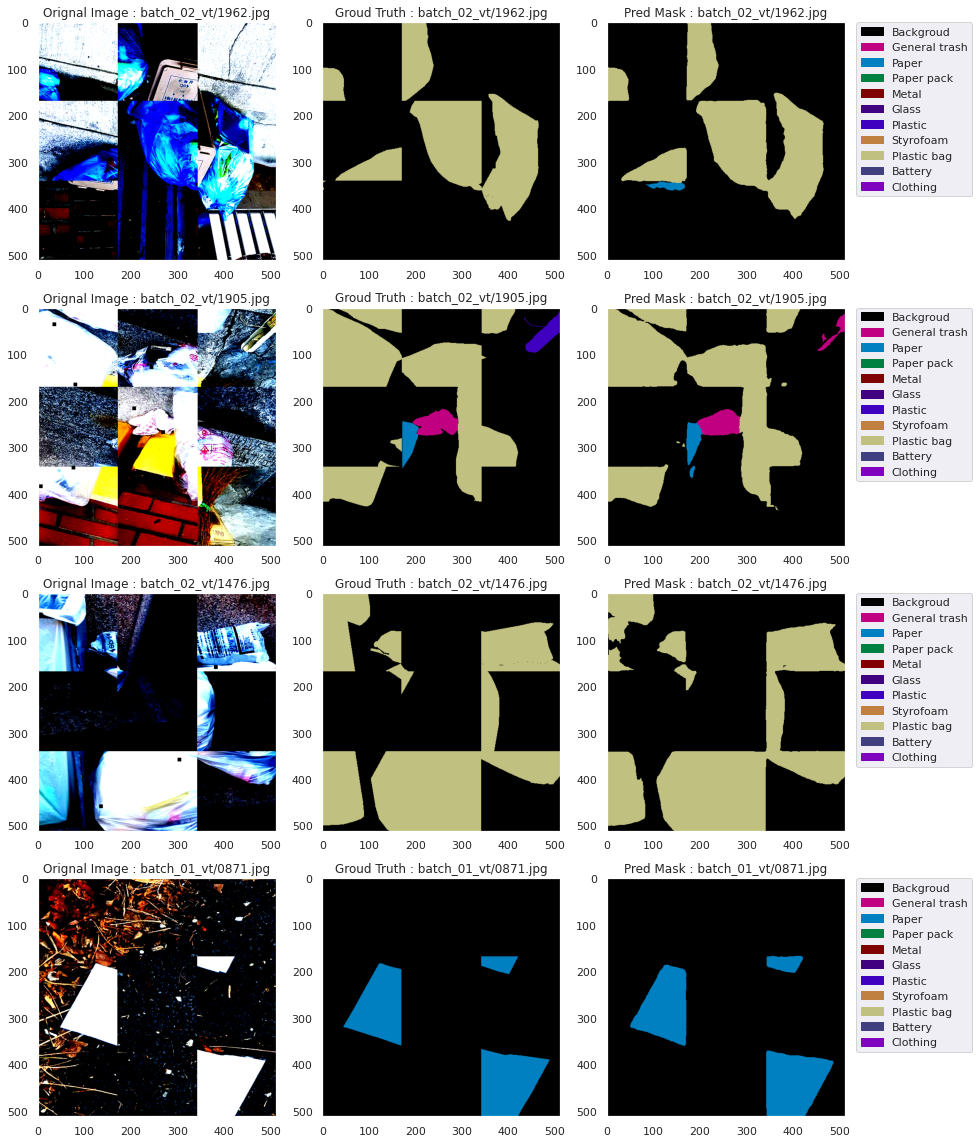

In [ ]:
plot_examples(mode="train", batch_id=7, num_examples=4, dataloaer=train_loader)

#### validation set 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


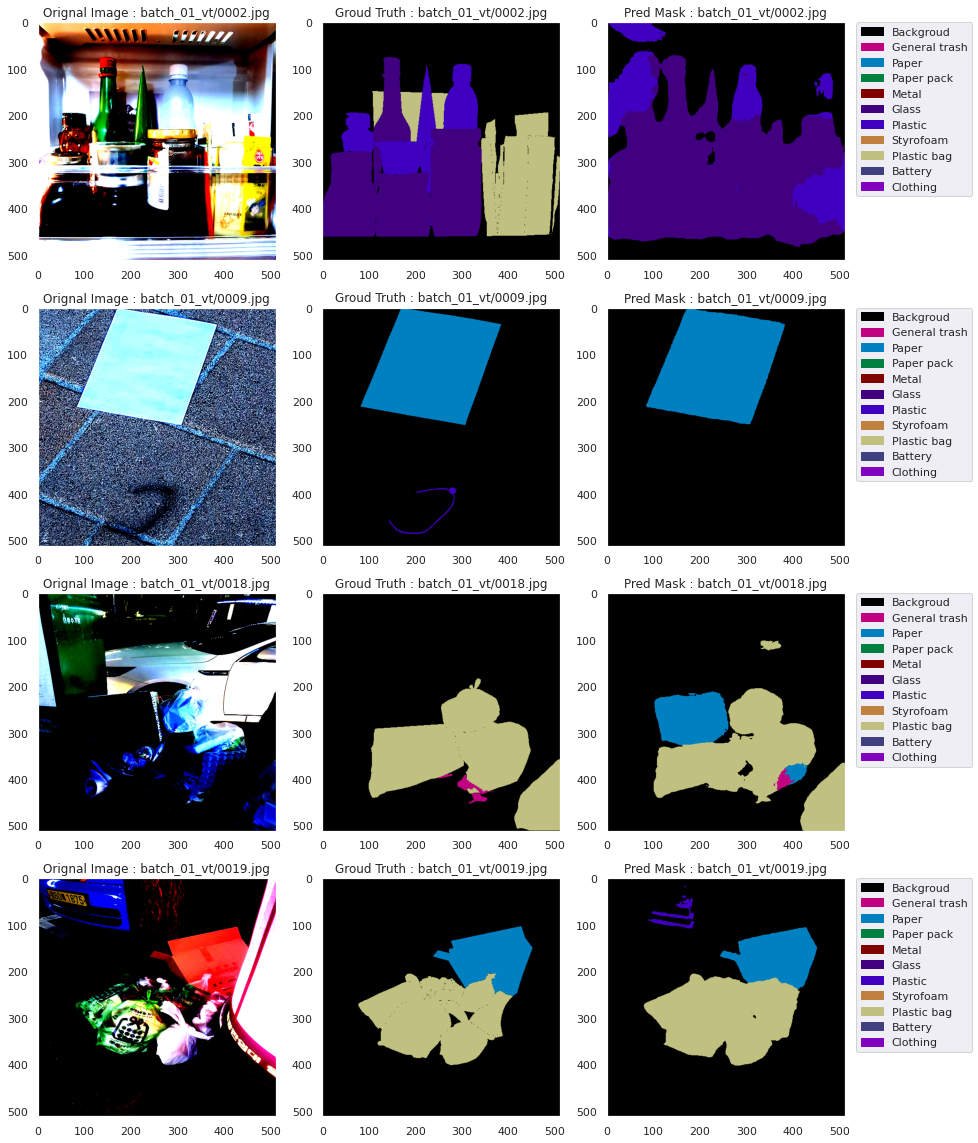

In [ ]:
plot_examples(mode="val", batch_id=0, num_examples=4, dataloaer=val_loader)

#### test set 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


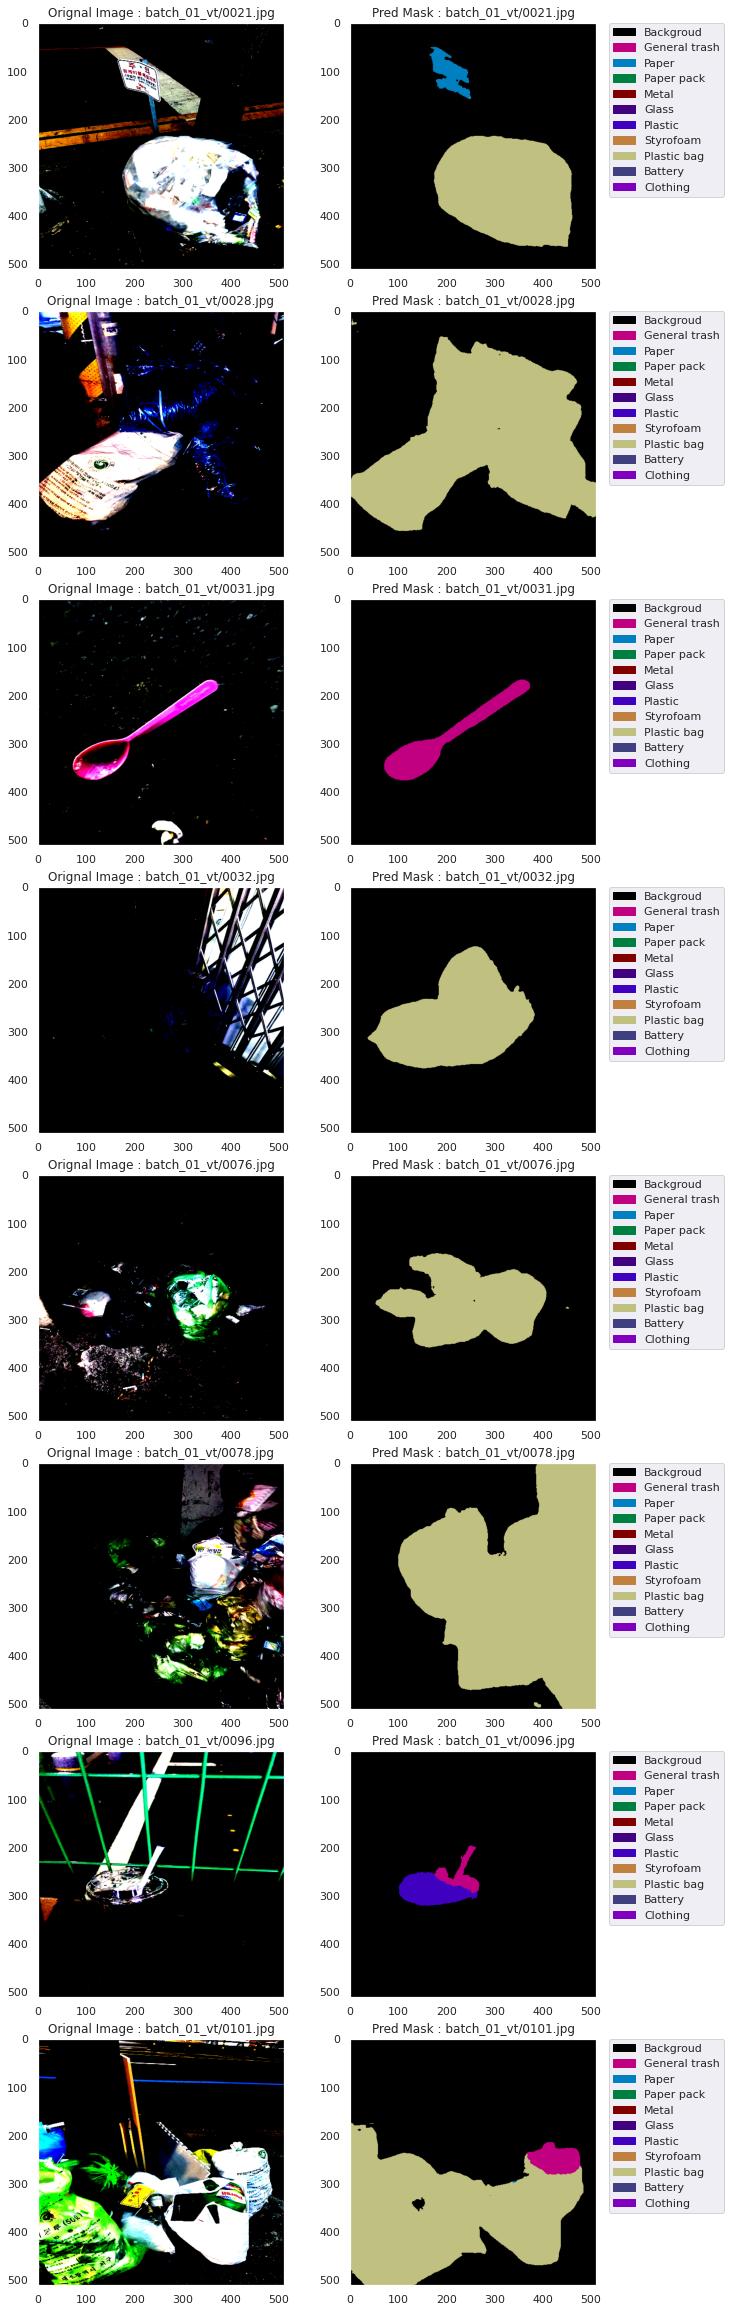

In [ ]:
plot_examples(mode="test", batch_id=0, num_examples=8, dataloaer=test_loader)

## submission을 위한 test 함수 정의

In [ ]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/deeplabv3plus_resnext50_epo20.csv", index=False)

  0%|          | 0/52 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 52/52 [06:01<00:00,  5.39s/it]


End prediction.
